<a href="https://colab.research.google.com/github/Ngoc-Quang-Minh-Nguyen/BCI-Motor-Imagery-Real-time-Unity-Control/blob/main/EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 **BCI Motor Imagery: Real-Time Unity Control**

### **Developer:** Ngoc Quang Minh Nguyen

### **System Specs:** 64-Channel EEG | Sampling Rate: **160Hz**

### **Objective:** Classify Mu **(8-12 Hz)** and Beta **(13-30 Hz)** rhythms to trigger movement in a virtual environment.


# 📋 **Phase 1: Data Ingestion & Formatting**

## **Action:** Converted raw CSV datasets into NumPy arrays.


## **Adjustment:** Make sure the datasets follow BrainFlow format (Channels, Samples).


In [ ]:
# Load the data
from google.colab import files
uploaded = files.upload()


Saving S001R11_nolb.csv to S001R11_nolb (1).csv


In [ ]:
import pandas as pd
df_1 = pd.read_csv("S001R03_nolb.csv", header=None)
df_2 = pd.read_csv("S001R07_nolb.csv", header=None)
df_3 = pd.read_csv("S001R11_nolb.csv", header=None)

In [ ]:
import numpy as np
# Seperate the features and labels
features_1 = df_1.iloc[0:64, :]
labels_1 = df_1.iloc[64, :]
features_2 = df_2.iloc[0:64, :]
labels_2 = df_2.iloc[64, :]
features_3 = df_3.iloc[0:64, :]
labels_3 = df_3.iloc[64, :]

labels_1 = labels_1.values.reshape(1, -1)
labels_2 = labels_2.values.reshape(1, -1)
labels_3 = labels_3.values.reshape(1, -1)

In [ ]:
print("--- Data Dimensions ---")
print(f"Original shape:   {df_1.shape}")
print(f"Features shape:   {features_1.shape}  (Channels, Samples)")
print(f"Labels shape:     {labels_1.shape}    (Channels, Samples)")

--- Data Dimensions ---
Original shape:   (65, 20000)
Features shape:   (64, 20000)  (Channels, Samples)
Labels shape:     (1, 20000)    (Channels, Samples)


In [ ]:
# Combine the files. 2 files for training, 1 for testing
x_train_unfiltered = np.concat([features_1, features_2], axis = 1)
y_train_unfiltered = np.concat([labels_1, labels_2], axis = 1)
x_test_unfiltered = features_3
y_test_unfiltered = labels_3

print("--- Data Dimensions ---")
print(f"Training features shape:   {x_train_unfiltered.shape} (Channels, Samples)")
print(f"Training labels shape:   {y_train_unfiltered.shape}  (Channels, Samples)")
print(f"Testing features shape:   {x_test_unfiltered.shape} (Channels, Samples)")
print(f"Testing labels shape:   {y_test_unfiltered.shape}  (Channels, Samples)")

--- Data Dimensions ---
Training features shape:   (64, 40000) (Channels, Samples)
Training labels shape:   (1, 40000)  (Channels, Samples)
Testing features shape:   (64, 20000) (Channels, Samples)
Testing labels shape:   (1, 20000)  (Channels, Samples)


In [ ]:
# Preliminary data analysis
print(y_train_unfiltered)

[[ 2.  2.  2. ... nan nan nan]]


# **Data Preprocessing: NaN Removal and Feature Synchronization**





---


**1. Problem Identification**

Preliminary data analysis revealed 80 invalid samples (NaN values) at the end of the test dataset. These values appear consistently across both the feature set (X) and the label set (Y). To ensure model integrity, these samples must be removed while maintaining strict alignment between features and labels.


---


**2. Synchronization Methodology**

To clean the data while preserving the "wide" BrainFlow format, the following two-stage process was implemented:

**Stage A: Label Set (Y) Filtering and Dimensionality Correction**

Boolean Masking: A boolean mask is generated by identifying non-NaN values

*   Boolean Masking: A boolean mask is generated by identifying non-NaN values within the y_test_unfiltered array.

*   Filtering: The mask is applied to the labels to extract only valid samples.

*   Dimensionality Reset: Because NumPy default behavior flattens filtered arrays into a 1D structure (changing the shape from **(1, 20000)** to **(19920,)**), the resulting array is reshaped back to a 2D "wide" format of **(1, 19920)**.

**Stage B: Feature Set ($X$) Alignment and Column-wise Indexing**

* **Mask Flattening:** The original mask has a shape of $(1, 20000)$. To filter the columns of a Pandas DataFrame, this mask is flattened into a 1D array to match the horizontal axis of the feature set.

* **Columnar Indexing:** Using the .iloc selector, the dataset is filtered by keeping all rows (channels) while selectively dropping columns (time-points) where the mask is False.
---
**3. Final Dataset Verification**

X: (64, 20000) -> (64, 19920)

y: (1, 20000) -> (1, 19920)

In [ ]:
# Create the mask (True for values that are NOT NaN)
is_not_nan = ~np.isnan(y_test_unfiltered)
mask_1D = is_not_nan.flatten()

# Apply the mask to X and Y at the same time
# Note: This works for both DataFrames and Numpy arrays
y_test_clean = y_test_unfiltered[is_not_nan]
y_test_clean = np.reshape(y_test_clean, (1, -1))
x_test_clean = x_test_unfiltered.iloc[:, mask_1D]

# Confirm the result
print(f"Clean Features Shape: {x_test_clean.shape}")
print(f"Clean Labels Shape: {y_test_clean.shape}")

Clean Features Shape: (64, 19920)
Clean Labels Shape: (1, 19920)


In [ ]:
# Same thing to training data, and we can't re-use the mask since it's (1, 20000)
# while the shape of the training data is doubled.

# Create the mask (True for values that are NOT NaN)
is_not_nan = ~np.isnan(y_train_unfiltered)
mask_1D = is_not_nan.flatten()

# Apply the mask to X and Y at the same time
# Note: This works for both DataFrames and Numpy arrays
y_train_clean = y_train_unfiltered[is_not_nan]
y_train_clean = np.reshape(y_train_clean, (1, -1))

# Convert to Pandas Dataframe since Numpy can't use <.iloc> function
x_train_unfiltered = pd.DataFrame(x_train_unfiltered)
x_train_clean = x_train_unfiltered.iloc[:, mask_1D]

# Confirm the result
print(f"Clean Features Shape: {x_train_clean.shape}")
print(f"Clean Labels Shape: {y_train_clean.shape}")

Clean Features Shape: (64, 39840)
Clean Labels Shape: (1, 39840)


# **Phase 2: Signal Filtering with BrainFlow**
Before feeding data into the Machine Learning model, the raw signal must undergo three specific digital signal processing (DSP) stages to isolate brain activity from physical and electrical noise.

**1. Digital Signal Processing (DSP) Pipeline**


*   **Linear Detrending** (Offset Correction):


    *   **Goal:** Centering the signal around a zero-baseline.

    *   **Rationale:** EEG signals frequently "drift" due to electrode-skin impedance changes. Detrending removes these low-frequency voltage shifts, allowing the model to analyze frequency fluctuations rather than absolute voltage values.


*  **Bandpass Filtering** **(8-30Hz)**:
   * **Goal:** Filter out the Motor Imaginary signature
   * **Rationale:** This project targets the Mu **(8-12Hz)** and Beta **(13-30Hz)** rhythms. These specific frequency bands are the primary indicators of a user imagining hand movement.
* **Notch Filter** on Electrical Hum:
   *   **Goal:** Remove electrical hum
   * **Rationale:** Standard wall outlets emit a **60HZ** frequency that acts as massive background noise. A notch filter (or bandstop) surgically removes this specific frequency without distorting our brain data.

---

**2. Memory Management: The C_CONTIGUOUS Requirement**

While the data orientation (Channels, Samples) was established in Phase 1, the BrainFlow C++ backend imposes strict requirements on how that data is stored in your computer's RAM.

* **The "Lazy" Transpose Issue:** In NumPy, transposing an array often creates a "view" rather than a new array. It changes the metadata (how we see the data) but leaves the actual physical memory layout untouched.
* **The BrainFlow Conflict:** Because BrainFlow is built in C++, it requires C-style contiguous memory (data stored in one continuous block, row by row). Passing a NumPy "view" to a BrainFlow function often results in errors or corrupted processing.
* **The Solution:** Regardless of the current shape, all arrays must be explicitly converted using np.ascontiguousarray() before being passed to BrainFlow functions. This forces NumPy to physically reorder the data in memory to comply with C++ requirements.

Technical Note: Even if the data is already in the correct (64, 19920) shape, verifying C_CONTIGUOUS status is a **mandatory** safety step for all raw data entering the filtering pipeline.

In [ ]:
!pip install brainflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 9.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations
import matplotlib.pyplot as plt


# Create a "Raw" copy for "Before and After"
x_train_raw = np.copy(x_train_clean)

# Mandatory safety check in case of C_contiguous.
x_train_bf = np.ascontiguousarray(x_train_clean)
x_train_raw = np.ascontiguousarray(x_train_raw)

# Start filtering for each channel.
for i in range(64):
    DataFilter.detrend(x_train_bf[i], DetrendOperations.LINEAR.value)

    DataFilter.perform_bandpass(x_train_bf[i], 160, 8.0, 30.0, 4,
                                FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandstop(x_train_bf[i], 160, 59.0, 61.0, 4,
                                FilterTypes.BUTTERWORTH.value, 0)


### After the filtering process:
- We need to plot the "Before and After" to see the result.
- Mostly, we will consider PSD to be our top priority. The peak needs to be in the 8-30 range.

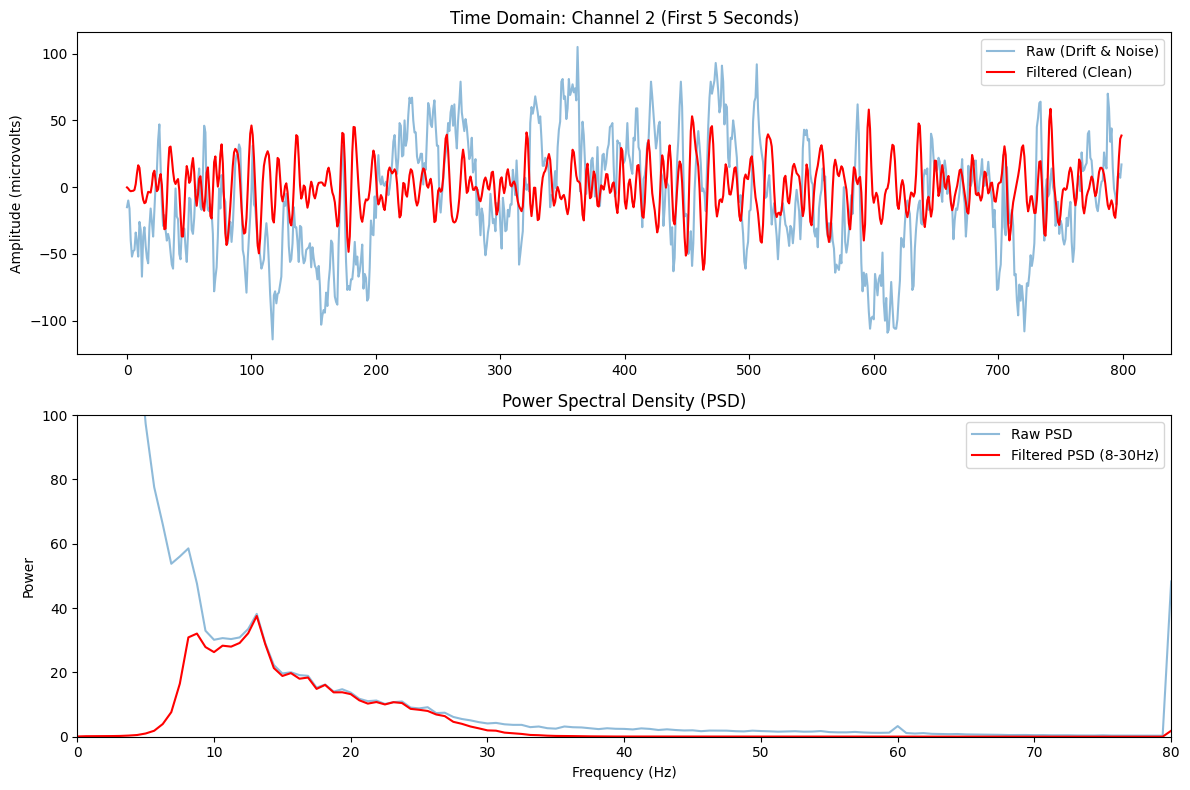

In [ ]:
# 4. Create the Comparison Plot (Channel 0 as an example)
ch = 2
sampling_rate = 160

plt.figure(figsize=(12, 8))

# Subplot 1: Time Domain (The "Waves")
plt.subplot(2, 1, 1)
plt.plot(x_train_raw[ch][:800], label='Raw (Drift & Noise)', alpha=0.5)
plt.plot(x_train_bf[ch][:800], label='Filtered (Clean)', color='red')
plt.title(f'Time Domain: Channel {ch} (First 5 Seconds)')
plt.ylabel('Amplitude (microvolts)')
plt.legend()

# Subplot 2: Frequency Domain (The "Ingredients" / PSD)
plt.subplot(2, 1, 2)
# Calculate PSD for Raw
psd_raw = DataFilter.get_psd_welch(x_train_raw[ch], 256, 128, sampling_rate, 0)
plt.plot(psd_raw[1], psd_raw[0], label='Raw PSD', alpha=0.5)

# Calculate PSD for Filtered
psd_filtered = DataFilter.get_psd_welch(x_train_bf[ch], 256, 128, sampling_rate, 0)
plt.plot(psd_filtered[1], psd_filtered[0], label='Filtered PSD (8-30Hz)', color='red')

plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 80) # Focus on the relevant range
plt.ylim(0,100)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Same process with testing data

# Create a "Raw" copy for "Before and After"
x_test_raw = np.copy(x_test_clean)

#Mandatory safety check in case of C_contiguous.
x_test_bf = np.ascontiguousarray(x_test_clean)
x_test_raw = np.ascontiguousarray(x_test_raw)
# Start filtering for each channel.
for i in range(64):
    DataFilter.detrend(x_test_bf[i], DetrendOperations.LINEAR.value)

    DataFilter.perform_bandpass(x_test_bf[i], 160, 8.0, 30.0, 4,
                                FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandstop(x_test_bf[i], 160, 59.0, 61.0, 4,
                                FilterTypes.BUTTERWORTH.value, 0)

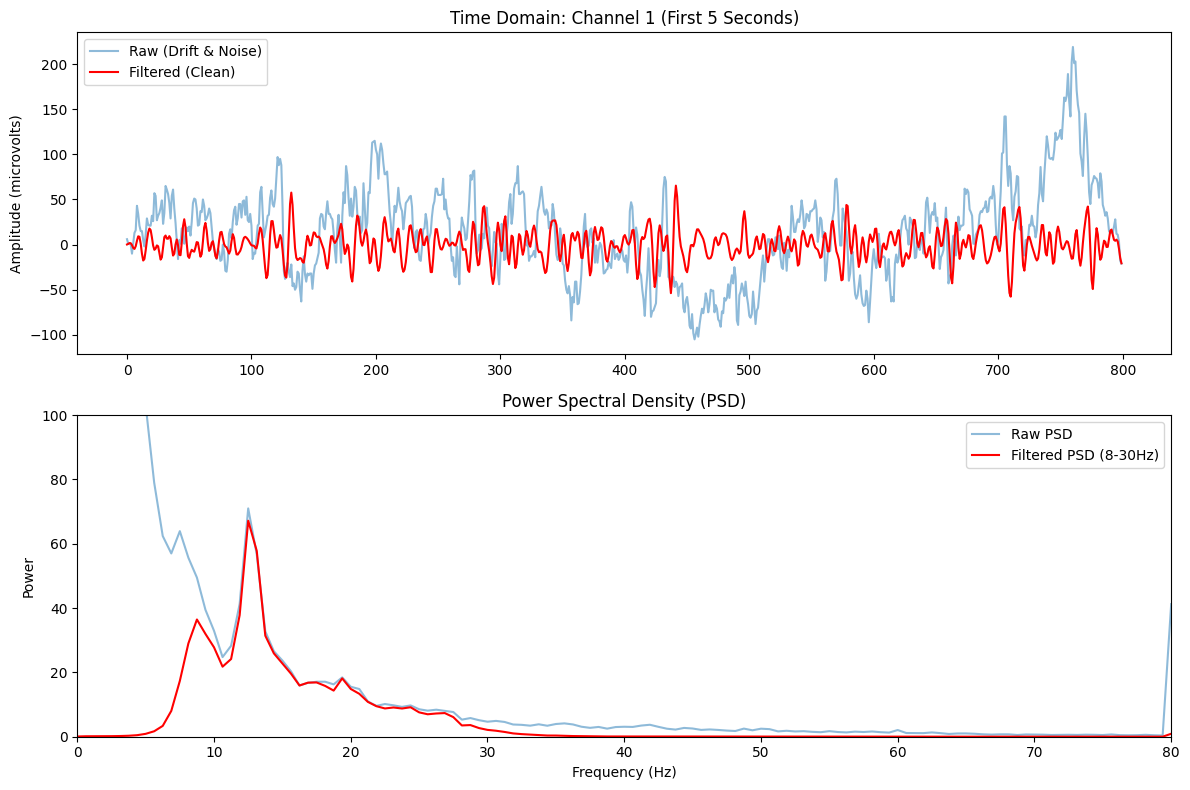

In [ ]:
# 4. Create the Comparison Plot (Channel 0 as an example)
ch = 1
sampling_rate = 160

plt.figure(figsize=(12, 8))

# Subplot 1: Time Domain (The "Waves")
plt.subplot(2, 1, 1)
plt.plot(x_test_raw[ch][:800], label='Raw (Drift & Noise)', alpha=0.5)
plt.plot(x_test_bf[ch][:800], label='Filtered (Clean)', color='red')
plt.title(f'Time Domain: Channel {ch} (First 5 Seconds)')
plt.ylabel('Amplitude (microvolts)')
plt.legend()

# Subplot 2: Frequency Domain (The "Ingredients" / PSD)
plt.subplot(2, 1, 2)
# Calculate PSD for Raw
psd_raw = DataFilter.get_psd_welch(x_test_raw[ch], 256, 128, sampling_rate, 0)
plt.plot(psd_raw[1], psd_raw[0], label='Raw PSD', alpha=0.5)

# Calculate PSD for Filtered
psd_filtered = DataFilter.get_psd_welch(x_test_bf[ch], 256, 128, sampling_rate, 0)
plt.plot(psd_filtered[1], psd_filtered[0], label='Filtered PSD (8-30Hz)', color='red')

plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 80) # Focus on the relevant range
plt.ylim(0,100)
plt.legend()

plt.tight_layout()
plt.show()

## **Result Validation: PSD Scaling**

**Observation:** The filtered PSD peak appears diminished when compared to the raw signal.

**Technical Explanation:** This is a visualization artifact caused by the removal of low-frequency "drift". The raw signal's offset (0 Hz) carries a power magnitude ~50x greater than the brain's Mu and Beta rhythms.

**Visualization Tip:** To verify the presence of Mu and Beta rhythms, the PSD y-axis should be constrained (e.g., ylim(0, 100)). This prevents the raw DC offset and low-frequency drift from dominating the plot's scale, making the filtered 8–30Hz peaks clearly visible for analysis.

**Conclusion:** The successful attenuation of the 0–5 Hz and 60 Hz bands confirms that the filter logic is correctly isolating the 8–30 Hz Motor Imagery band, even if the resulting peaks are numerically smaller than the raw noise.


In [ ]:
print("--- Data Dimensions ---")
print(f"Training features shape:   {x_train_bf.shape} (Channels, Samples)")
print(f"Training labels shape:   {y_train_clean.shape}  (Channels, Samples)")
print(f"Testing features shape:   {x_test_bf.shape} (Channels, Samples)")
print(f"Testing labels shape:   {y_test_clean.shape}  (Channels, Samples)")

--- Data Dimensions ---
Training features shape:   (64, 39840) (Channels, Samples)
Training labels shape:   (1, 39840)  (Channels, Samples)
Testing features shape:   (64, 19920) (Channels, Samples)
Testing labels shape:   (1, 19920)  (Channels, Samples)


# **PHASE 3: FEATURE EXTRACTION**

**1. Objective:** To transform segmented 3D EEG windows into a 2D feature matrix optimized for Motor Imagery classification. This phase reduces high-dimensional raw data into a set of frequency-based power features.



**2. Step-by-step Pipeline**


*   Step 1: Data Segmentation  
      * The continuous EEG data is going to be "chopped" into 540 overlapping windows of shape (64, 128).
      * **Goal**: Ensure that each window represent a single mental state (Rest, Left, or Right).



*   **Step 2: Common Spatial Patterns**
      * **Logic**: Uses a One-vs-All (OvA) approach to find spatial filters that maximize the difference between classes.
      * **Output**: Returns a 64 x 64 filter matrix and 64 eigenvalues.
      * **Purpose**: To condense 64 physical electrodes into several "virtual" channels that highlight the mental state.
* **Step 3: Frequency to Feature**

    * **Welch's PSD**: Converts the time-domain windows into frequency maps.

    * **Band Power Extraction**: Summarizes these maps by calculating the average power in the Mu (8-12 Hz) and Beta (13-30 Hz) bands.

* **Step 4: Feature Matrix Construction**

    * The results from Step 3 are flattened into a final 2D matrix.


    * **Structure**: Each row represents one window; each column represents a specific power of the 2 bands.

**3. Summary**

* **Input Shape**: (540, 64,128) (Epochs, Channels, Samples)

* **Process**: CSP -> PSD -> Avg Power -> Matrix

* **Final Shape**: (540, N_features)

## Data Segmentation
### 1. **Objective:**
* Transform EEG recording into discrete, labeled snapshots (windows) suitable for Machine Learning.
     * This segmentation must respect experimental trial boundaries to prevent "label contamination", where a window has recording belong to two different labels.

### 2. **Input Data Specifications**
* Source Data: 64-channel EEG array with a sampling rate of 160Hz
* Total Samples: 39,840
* Trial Stucture:
     * Action Trials: 656 samples (4.1s)
     * Rest Trials: 672 samples (4.2s)
* Trial Sequence: 30 cycles of alternating Action (Left, Right) and Rest trials.

### 3. **Windowing Parameters**
* Window Size: 128 samples (for better frequency resolution)
* Step Size: 64 samples (50% overlap)
* Constraint: Windows are strictly contained within their respective trials. Any samples remaining at the end of a trial that cannot form a full 128-sample window are discarded.

### 4. **Implementation Logic**:

The algorithm utilizes a nested loop structure to traverse the dataset:

1. **Outer Loop:** Iterates through trial_info, which defines the duration and label for each segment.
2. **Window Calculation:** For each trial, the number of valid windows is calculated using the formula:

      **(Duration - Window_Size) // Step_Size + 1**
3. **Inner Loop:** Extracts slices from the raw EEG array.
* **Start Index**: trial_start + (i * step_size)
* **End Index**: start + window_size (ensure same window length)

4. **Labeling:** Each extracted window is assigned the label associated with its parent trial.

### **5. Final Output Structure**

* **Feature Array (X)**: A 3D NumPy array of shape (540, 64, 128)

     * 540: Total number of extracted windows (Epochs)
     * 64: Number of EEG channels
     * 128: Samples (Length of the window)

* **Label Array (y)**: A 1D NumPy array of shape (540,) containing the corresponding class tags.

In [ ]:
# Preparing stuff-ish.
label_list_1 = ["Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest"]
label_list_2 = ["Left", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest"]
label_list_3 = ["Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest"]
training_label = label_list_1 + label_list_2
testing_label = label_list_3

In [ ]:

def prepare_trial(label):
  trial_info = [] # Will be in format (duration, label)
  for info in label:
    if info == "Left":
      trial_info.append((656, 1))
    elif info == "Right":
      trial_info.append((656, 2))
    elif info == "Rest":
      trial_info.append((672, 0))
  return trial_info
trial_info_training = prepare_trial(training_label)
trial_info_testing = prepare_trial(testing_label)

[(656, 2), (672, 0), (656, 1), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 2), (672, 0), (656, 1), (672, 0), (656, 1), (672, 0)]


In [ ]:
def split_window(trial_info, data, window_size=128, steps=64):
    curr_indx = 0
    all_windows = []
    all_labels = []

    for duration, label in trial_info:
        trial_start = curr_indx
        trial_end = trial_start + duration
        # Calculation for num_windows
        num_windows = (duration - window_size) // steps + 1

        for i in range(num_windows):
            start = trial_start + (i * steps)
            end = start + window_size
            window = data[:, start:end]

            all_windows.append(window)
            all_labels.append(label)

        curr_indx = trial_end

    # --- MOVE THESE OUTSIDE THE FOR LOOP ---
    X = np.array(all_windows)
    y = np.array(all_labels)
    return X, y
X_train, y_train = split_window(trial_info_training, x_train_bf)
X_test, y_test = split_window(trial_info_testing, x_test_bf)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(540, 64, 128)
(540,)
(270, 64, 128)
(270,)


## Common Spatial Patterns
### 1. **Objective:**
* Create filters that maximize the signal variance for one class while minimizing the others.This technique is essential for Motor Imagery tasks because it transform electrodes into "virtual" channels that highlight specific motor cortex activity related to different movements.

### 2. **Implementation Approach**
* Because this is a 3-class project (Rest, Left, Right), a One-vs-All (OvA) strategy was implemented:

     * Rest vs All
     * Left vs All
     * Right vs All

### 3. **Filter Selection and Logic**
* The BrainFlow get_csp function returns a full 64x64 matrix of potential filters and a corresponding 1D array of **eigenvalues**
* The eigenvalues represent discrepancy: Values closer to 1.0 or 0.0 indicate high discrepancy power, while values near 0.5 indicate noise.
* For each of the three model, the 3 highest and 3 lowest filters were selected
* Final Filters: A total of 18 spatial filters (6 filters x 3 classes) that effectively capture the unique "signatures" of each mental state.

### 4. **Apply Filters to Raw Data**:

These 18 selected filters (**W**) are applied to each 128-sample EEG window (**X**) via matrix multiplication (**W . X**). This process reduces the data from 64 raw channels down to 18 virtual signals, cleaning the data and preparing it for frequency analysis.


In [ ]:
from brainflow.data_filter import DataFilter

In [ ]:

def main_vs_all(label, y):
  new_array = []
  for i in range(y.size):
    if y[i] == label:
      new_array.append(1)
    else:
      new_array.append(0)
  return np.array(new_array).astype(float)

# Convert array to OvA
rest_vs_all_train = main_vs_all(0, y_train)
left_vs_all_train = main_vs_all(1, y_train)
right_vs_all_train = main_vs_all(2, y_train)

rest_vs_all_test = main_vs_all(0, y_test)
left_vs_all_test = main_vs_all(1, y_test)
right_vs_all_test = main_vs_all(2, y_test)



In [ ]:
# Apply CSP
csp_array_rest = []
csp_array_left = []
csp_array_right = []

def csp_process(X ,array):
  csp_bin = DataFilter.get_csp(X, array)
  return csp_bin
# Apply CSP
csp_array_rest_train = csp_process(X_train, rest_vs_all_train)
csp_array_left_train = csp_process(X_train, left_vs_all_train)
csp_array_right_train  = csp_process(X_train, right_vs_all_train)

csp_array_rest_test = csp_process(X_test, rest_vs_all_test)
csp_array_left_test = csp_process(X_test, left_vs_all_test)
csp_array_right_test  = csp_process(X_test, right_vs_all_test)
# np.set_printoptions(threshold=np.inf, suppress=True, precision=4)
# print(csp_array_left[0])

In [ ]:

# This unpacks all filters and all eigenvalues into two neat groups
(filters_left_train, eigens_left_train), (filters_right_train, eigens_right_train), (filters_rest_train, eigens_rest_train) = [csp_array_left_train, csp_array_right_train, csp_array_rest_train]
(filters_left_test, eigens_left_test), (filters_right_test, eigens_right_test), (filters_rest_test, eigens_rest_test) = [csp_array_left_test, csp_array_right_test, csp_array_rest_test]

In [ ]:
# Pick out 18 filters that are effective (both training and testing)
filters_all_train = np.concat([filters_left_train[:3], filters_left_train[-3:], filters_right_train[:3], filters_right_train[-3:], filters_rest_train[:3], filters_rest_train[-3:]], axis = 0)
filters_all_test = np.concat([filters_left_test[:3], filters_left_test[-3:], filters_right_test[:3], filters_right_test[-3:], filters_rest_test[:3], filters_rest_test[-3:]], axis = 0)
print(filters_all_train.shape)
print(filters_all_test.shape)

(18, 64)
(18, 64)


In [ ]:
# Apply filters to raw data using matrix multiplication
def filter_add_data(X, filters):
  X_transformed = []
  for window in X:
    virtual_signals = np.dot(filters, window)
    X_transformed.append(virtual_signals)
  return np.array(X_transformed)

X_train_transformed = filter_add_data(X_train, filters_all_train)
X_test_transformed = filter_add_data(X_test, filters_all_test)
print(X_train_transformed.shape)
print(X_test_transformed.shape)


(540, 18, 128)
(270, 18, 128)


## Frequency Analysis & Feature Extraction
### 1. **Objective:**
* Convert those 18 spatially "virtual signals" into numerical features that represent the power of the Mu and Beta brain activity power.

### 2. **Power Spectral Density (PSD)**
For every transformed window, we apply **Welch’s Method** to estimate the power spectrum:
* Create a for-loop to iterate through each of the 18 virtual signals (128 samples long)
* **FFT Parameters**: We utilize an *nfft* of 128 and an overlap of 64 samples (50% overlap) to ensure frequency resolution matches our window length.
* **Windowing Function:** A *Hanning window* (Type 1) is applied to the data segments to reduce spectral leakage and smooth the frequency "edges"
### 3. **Band Power Extraction**
The resulting PSD is distilled into two primary frequency bands of interest: **Mu Band (8-12 Hz) & Beta Band (13-30 Hz)**
* The *get_band_power* method averages the energy within these specific ranges for each of the 18 virtual channels.

### 4. **Final Feature Matrix Construction**:

The output is a structured 2D array ready for machine learning:

1. **Feature Vector**: Each window is represented by **36 features** (*18 virtual channels x 2 frequency bands*)
2. **Data Shape**: (540, 36), where 540 is the number of epochs

* We now have X and y ready to be used in ML model



In [ ]:
def signals_to_features(X):
  X_final = []
  for window in X:
    window_row = []
    for i in range(18):
      signal = window[i]
      psd = DataFilter.get_psd_welch(signal, 128, 64, 160, 1)

      mu_pwr = DataFilter.get_band_power(psd, 8.0, 12.0)
      beta_pwr = DataFilter.get_band_power(psd, 13.0, 30.0)

      window_row.append(mu_pwr)
      window_row.append(beta_pwr)
    X_final.append(window_row)

  return np.array(X_final)

X_train = signals_to_features(X_train_transformed)
X_test = signals_to_features(X_test_transformed)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(540, 36)
(270, 36)
(540,)
(270,)
